In [46]:
# pip install torch torchvision matplotlib
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import math

In [47]:
# ---- Config ----
latent_dim = 2       # try 2, 3, 8, 16
beta = 1.0           # try 2.0 or 4.0 for β-VAE
epochs = 10
batch_size = 128
lr = 1e-3
prior_var = 1  # change this to experiment
prior_logvar = math.log(prior_var)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [48]:
# ---- Data ----
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root="../data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="../data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [49]:
# ---- Model ----
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
        )
        self.mu = nn.Linear(256, latent_dim)
        self.logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        h = self.net(x)
        return self.mu(h), self.logvar(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 28*28),
        )

    def forward(self, z):
        x = self.net(z)
        return torch.sigmoid(x).view(-1, 1, 28, 28)

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.enc = Encoder(latent_dim)
        self.dec = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        mu, logvar = self.enc(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.dec(z)
        return x_hat, mu, logvar

def loss_fn(x, x_hat, mu, logvar, beta=1.0):
    recon = F.binary_cross_entropy(x_hat, x, reduction='sum') / x.size(0)
    # KL for diagonal Gaussians
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon + beta * kl, recon, kl


In [50]:
model = VAE(latent_dim).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=lr)

In [51]:
# ---- Train ----
for epoch in range(1, epochs+1):
    model.train()
    total, recon_t, kl_t = 0, 0, 0
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x)
        loss, recon, kl = loss_fn(x, x_hat, mu, logvar, beta)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item(); recon_t += recon.item(); kl_t += kl.item()
    print(f"Epoch {epoch:02d}: loss={total/len(train_loader):.2f}  recon={recon_t/len(train_loader):.2f}  kl={kl_t/len(train_loader):.2f}")

Epoch 01: loss=181.32  recon=177.24  kl=4.08
Epoch 02: loss=159.34  recon=153.99  kl=5.35
Epoch 03: loss=153.75  recon=148.01  kl=5.74
Epoch 04: loss=150.41  recon=144.43  kl=5.98
Epoch 05: loss=148.35  recon=142.24  kl=6.11
Epoch 06: loss=146.80  recon=140.58  kl=6.22
Epoch 07: loss=145.56  recon=139.27  kl=6.30
Epoch 08: loss=144.77  recon=138.43  kl=6.33
Epoch 09: loss=143.83  recon=137.43  kl=6.41
Epoch 10: loss=143.11  recon=136.67  kl=6.43


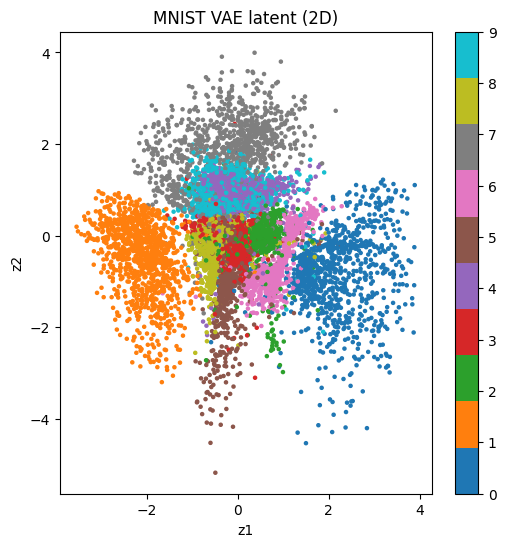

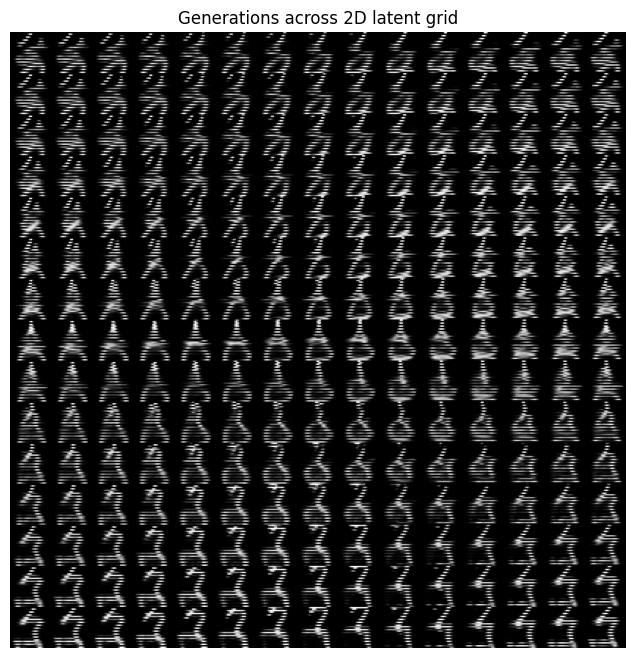

In [52]:
# ---- Evaluate: visualize 2D latent ----
model.eval()
all_z, all_y = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        mu, logvar = model.enc(x)
        z = mu # use mean for visualization
        all_z.append(z.cpu()); all_y.append(y)
all_z = torch.cat(all_z).numpy()
all_y = torch.cat(all_y).numpy()

if latent_dim == 2:
    plt.figure(figsize=(6,6))
    scatter = plt.scatter(all_z[:,0], all_z[:,1], c=all_y, s=5, cmap="tab10")
    plt.title("MNIST VAE latent (2D)")
    plt.xlabel("z1"); plt.ylabel("z2"); plt.colorbar(scatter, ticks=range(10))
    plt.show()

# ---- Optional: sample grid from 2D latent ----
if latent_dim == 2:
    with torch.no_grad():
        grid_x = torch.linspace(-3, 3, steps=15)
        grid_y = torch.linspace(-3, 3, steps=15)
        imgs = []
        for yi in grid_y:
            for xi in grid_x:
                z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
                imgs.append(model.dec(z).cpu())
        imgs = torch.cat(imgs, dim=0).view(15*28, 15*28)
        plt.figure(figsize=(8,8))
        plt.imshow(imgs, cmap="gray")
        plt.axis("off"); plt.title("Generations across 2D latent grid")
        plt.show()